In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m,ei): #epsilon = ei*m
    return ((l**(1/k))*(ei*m))/(2*((k-1)**((k-1)/k)))

In [5]:
def DOSS_chi2_test_positive(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            else:
                x[i+int(n/2)][j] = 3
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

def DOSS_chi2_test_negative(n,m):
    x = np.ones((n,m))
    for j in range(m):
        for i in range(int(n/2)):
            if i < 1:
                x[i][j] = 0
            elif i < int((n-2)/4):
                x[i][j] = 2
            else:
                x[i][j] = 4
        for i in range(int(n/2)):
            if i < 1:
                x[i+int(n/2)][j] = 1
            elif i < int((n+2)/4):
                x[i+int(n/2)][j] = 3
            else:
                x[i+int(n/2)][j] = 5
    DOLSP, DOLSN = DOLS_chi2(x,n,m)
    #LS = max(max(DOLSP), max(DOLSN))
    #print(LS/min(DOLSP), LS/min(DOLSN))
    return DOLSP, DOLSN

In [6]:
def accuracy_positive(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,0)
                    acc[i][0] += math.fabs((DOLSP[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

def accuracy_negative(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,1)
                    acc[i][0] += math.fabs((DOLSN[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

[[0.30298484 0.40397979]
 [0.17185431 0.22913908]
 [0.20655096 0.27540128]
 [0.15909419 0.21212559]
 [0.11821528 0.15762038]
 [0.10221666 0.13628888]
 [0.14660557 0.19547409]
 [0.07916701 0.10555601]]
[[0.32144629 0.42859505]
 [0.18244249 0.24325665]
 [0.18439723 0.24586297]
 [0.19221619 0.25628826]
 [0.10751075 0.14334767]
 [0.12135683 0.16180911]
 [0.09882301 0.13176402]
 [0.07688648 0.1025153 ]]
[[0.430043   0.57339067]
 [0.24352814 0.32470419]
 [0.18570039 0.24760052]
 [0.12434324 0.16579099]
 [0.10518368 0.1402449 ]
 [0.11036142 0.14714855]
 [0.10533882 0.14045176]
 [0.07884122 0.10512162]]
[[0.30841468 0.41121957]
 [0.20769122 0.27692163]
 [0.2150215  0.28669534]
 [0.16398104 0.21864139]
 [0.16289508 0.21719344]
 [0.09732981 0.12977308]
 [0.09303119 0.12404159]
 [0.06320329 0.08427105]]
[[0.27692163 0.36922884]
 [0.23131101 0.30841468]
 [0.22023414 0.29364553]
 [0.18624337 0.2483245 ]
 [0.14800181 0.19733575]
 [0.06149289 0.08199052]
 [0.09447915 0.12597219]
 [0.07232541 0.096433

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


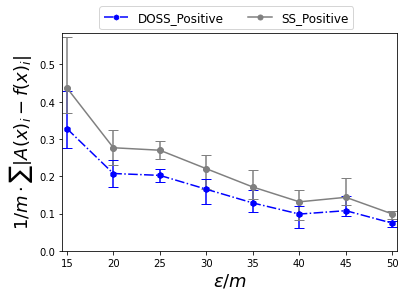

In [7]:
n = 150; m = 4

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_positive(n,m)

jj = 5
for j in range(jj):
    acc = accuracy_positive(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Positive")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Positive")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_positive_m=4.png")
fig.savefig("figs/Accuracy_chi2_positive_m=4.eps", bbox_inches="tight", pad_inches=0.05)

[[0.10963943 0.1461859 ]
 [0.06827416 0.09103221]
 [0.04465731 0.05954308]
 [0.0525296  0.07003946]
 [0.02527309 0.03369746]
 [0.01953757 0.0260501 ]
 [0.01870264 0.02493685]
 [0.04199505 0.0559934 ]]
[[0.0569667  0.0759556 ]
 [0.05517755 0.07357006]
 [0.07540216 0.10053621]
 [0.0317754  0.04236719]
 [0.02576383 0.03435178]
 [0.0304872  0.04064961]
 [0.0322525  0.04300334]
 [0.02791082 0.03721443]]
[[0.08673824 0.11565099]
 [0.04981008 0.06641344]
 [0.0492948  0.0657264 ]
 [0.02676576 0.03568768]
 [0.03643742 0.04858323]
 [0.02726672 0.03635563]
 [0.02624094 0.03498792]
 [0.01657473 0.02209964]]
[[0.05038261 0.06717681]
 [0.06763007 0.09017342]
 [0.04276797 0.05702395]
 [0.03463804 0.04618406]
 [0.02858559 0.03811412]
 [0.03370768 0.04494358]
 [0.02614552 0.03486069]
 [0.02198514 0.02931352]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.07872283 0.10496377]
 [0.03542527 0.0472337 ]
 [0.05564988 0.07419984]
 [0.04236719 0.05648959]
 [0.03189808 0.04253077]
 [0.02844757 0.03793009]
 [0.02366456 0.03155275]
 [0.02069695 0.02759593]]
[[0.07648996 0.10198662]
 [0.05526342 0.07368457]
 [0.05355442 0.0714059 ]
 [0.0376152  0.0501536 ]
 [0.0295916  0.03945547]
 [0.02788935 0.0371858 ]
 [0.02540123 0.03386831]
 [0.02583254 0.03444338]]


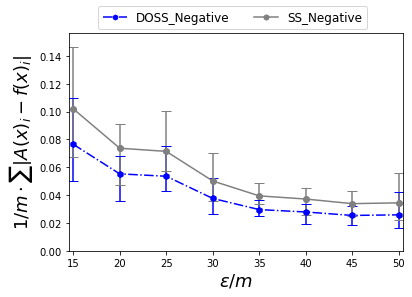

In [8]:
n = 150; m = 4

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test_negative(n,m)

jj = 5
for j in range(jj):
    acc = accuracy_negative(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS_Negative")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS_Negative")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_negative_m=4.png")
fig.savefig("figs/Accuracy_chi2_negative_m=4.eps", bbox_inches="tight", pad_inches=0.05)